In [528]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set display options to show all columns
pd.set_option('display.max_columns', None)

CWD = os.getcwd()
print(f'CWD: {CWD}')

CWD: /data_analysis/IT_support/src


In [529]:
ROOT = os.path.dirname(CWD)
PATH = os.path.join(ROOT, 'data', 'incident_event_log.csv')

df = pd.read_csv(PATH, low_memory=False, na_values='?')
df.sample(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
35610,INC0007933,Closed,False,3,0,14,False,Caller 5549,Opened by 55,16/3/2016 16:17,Created by 30,16/3/2016 16:22,Updated by 908,26/3/2016 16:59,Phone,Location 161,Category 19,Subcategory 174,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 24,Resolver 253,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 231,21/3/2016 16:44,26/3/2016 16:59
7127,INC0001693,Active,True,0,0,1,True,Caller 2607,Opened by 460,3/3/2016 09:39,Created by 199,3/3/2016 09:41,Updated by 833,3/3/2016 09:44,Phone,Location 2,Category 24,Subcategory 164,NaN,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 23,Resolver 215,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 196,3/3/2016 09:46,7/3/2016 10:18
78637,INC0018665,Closed,False,1,0,3,True,Caller 2310,Opened by 500,13/4/2016 13:08,Created by 217,13/4/2016 13:18,Updated by 908,18/4/2016 16:07,Phone,Location 204,Category 35,Subcategory 28,Symptom 506,NaN,2 - Medium,2 - Medium,3 - Moderate,NaN,Resolver 17,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 15,13/4/2016 15:56,18/4/2016 16:07
24300,INC0005400,Active,True,2,0,5,True,Caller 3452,Opened by 17,10/3/2016 12:30,Created by 10,10/3/2016 12:39,Updated by 703,18/3/2016 14:36,Phone,Location 55,Category 53,Subcategory 82,Symptom 534,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 66,Resolver 17,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 7,Resolved by 15,21/3/2016 11:16,26/3/2016 11:59
109750,INC0026583,New,True,2,0,5,True,Caller 3124,Opened by 58,5/5/2016 19:14,NaN,NaN,Updated by 429,10/5/2016 14:47,Phone,Location 204,Category 57,Subcategory 23,Symptom 296,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,NaN,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 15,18/5/2016 08:34,23/5/2016 09:07


## Analysis

It appears that tickets with higher priority have shorter lifetimes, but the medians are very close. Higher priority tickets are also being updated faster. We have also checked how many days a ticket closes once it has reached a certain *state*. It is curious to see that when a ticket was marked as resolved, it is almost always 5 days before it was finally closed.

### Tickets

Tickets are logged everytime it is updated. This can be seen by showing all tickets with the same ticket `number`. Even for tickets that were reopened (`reopen_count` > 0), the `resolved_at` and `closed_at` columns only reflect the time & date of the last resolution and closing.

Based on `incident_response.txt` that details the description for each column, we split them to their appropriate data type. Most of them are categorical in nature. I separated those categories into the foloowing:
- w**ordinal columns** (ranking/order in time is implied by category). 
- **boolean** (binary T/F values)
- **cardinal** (more than two values).

One issue that I notice is that information is duplicated across incident states. By my understanding, some of these columns were only populated during a certain state, and should've been unknown at an earlier state. One example is `closed_code`, this information looks like it was only added at the last state and should be blank during earlier states. Since we don't have clear information as to when these columns' information were made known, we would exclude them  for now.

In [530]:
cols = ['number', 'sys_mod_count', 'incident_state', 'caller_id', 'assignment_group',
        'opened_at', 'sys_updated_at', 'sys_created_at', 'closed_at', 'closed_code']
# cond = (df['number']=='INC0000065')
cond = (df['number']=='INC0000074')
# cond = (df['reassignment_count']>1)
df.loc[cond, cols]

,number,sys_mod_count,incident_state,caller_id,assignment_group,opened_at,sys_updated_at,sys_created_at,closed_at,closed_code
99,INC0000074,0,Active,Caller 527,Group 66,29/2/2016 08:23,29/2/2016 08:23,NaN,16/4/2016 15:07,code 6
100,INC0000074,1,Awaiting User Info,Caller 527,Group 66,29/2/2016 08:23,29/2/2016 08:38,NaN,16/4/2016 15:07,code 6
101,INC0000074,2,Awaiting User Info,Caller 527,Group 66,29/2/2016 08:23,29/2/2016 14:16,NaN,16/4/2016 15:07,code 6
102,INC0000074,9,Awaiting User Info,Caller 527,Group 66,29/2/2016 08:23,21/3/2016 11:07,NaN,16/4/2016 15:07,code 6
103,INC0000074,18,Resolved,Caller 527,Group 66,29/2/2016 08:23,11/4/2016 14:39,NaN,16/4/2016 15:07,code 6
104,INC0000074,19,Closed,Caller 527,Group 66,29/2/2016 08:23,16/4/2016 15:07,NaN,16/4/2016 15:07,code 6


Listed down the features that will be used. Since most models cannot handle date time columns directly, the target `close_at` will be replaced by the duration since last update.
`target = closed_at - sys_updated_at`

In [531]:
cardinal_cols = ['number', 'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by', 'contact_type', 'location', 'u_symptom']
ordinal_cols = ['incident_state', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'impact', 'urgency', 'priority']

boolean_cols = ['cmdb_ci', 'u_priority_confirmation',]

dt_cols = ['opened_at', 'sys_created_at', 'sys_updated_at', 'closed_at']

# to_remove = ['made_sla', 'knowledge', 'notify', 'problem_id', 'rfc', 'vendor', 'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
#              'assignment_group', 'assigned_to', 'category', 'subcategory', 'active']

all_cols = cardinal_cols + ordinal_cols + boolean_cols + dt_cols
len(all_cols)

21

In [532]:
# Convert the date columns in proper format so we can do calculations on them
for col in dt_cols:
    df[col] = pd.to_datetime(df[col], dayfirst=True)

It is hard to properly order the `incident_state` since they sometimes flip back between *Active* and *Awaiting...*. Some revert from *Resolved* to *Active* again when reopened. The entries with `incident_state == -100` will just be converted to NaN

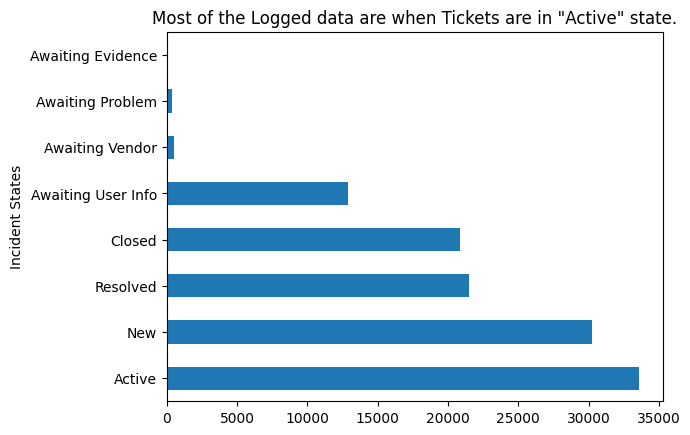

In [533]:
df[df['incident_state']=='-100'] = np.nan
df['incident_state'].value_counts().plot(kind='barh')
plt.title(f'Most of the Logged data are when Tickets are in "Active" state.')
plt.ylabel('Incident States')
plt.show()

The `sys_mod_count` tells us how many times a ticket is updated. It stands to reason that the max `sys_mod_count` for each `number` should be equal to the rows with that `number`. There are however multiple instances where this is not the case. It appears that there are missing rows for those incident tickets.

In [534]:
numbers = df.groupby('number')['number'].transform('count')
df.loc[df['sys_mod_count']>numbers, 'number'].unique().shape

(5041,)

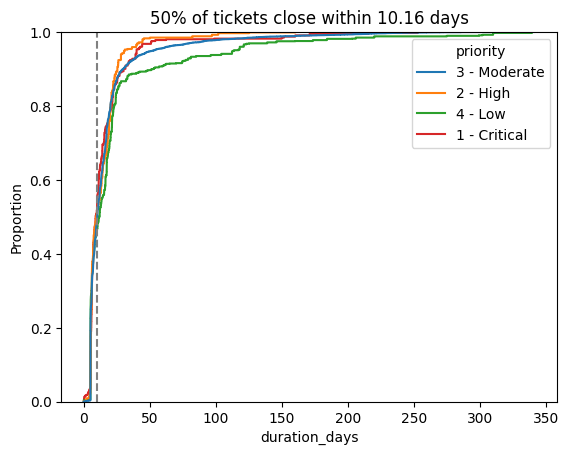

In [535]:
df['duration_days'] = df['closed_at']-df['opened_at']
df['duration_days'] = df['duration_days'].dt.days + df['duration_days'].dt.seconds / (24 * 60 * 60) #Convert time delta to "days"
dd_median = df['duration_days'].median()
# sns.boxplot(df, y='duration_days', x='priority', showfliers=False)
sns.ecdfplot(data=df, x='duration_days', hue='priority', stat='proportion')
plt.axvline(x=dd_median, color='gray', linestyle='--', label='Median')
plt.title(f'50% of tickets close within {dd_median:.2f} days')
plt.show()

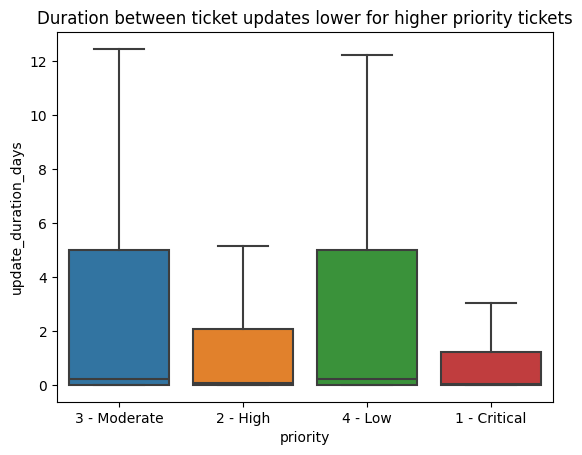

In [536]:
# Sort the DataFrame by 'number' and 'sys_updated_at'
df.sort_values(['number', 'sys_updated_at'], inplace=True)

# Calculate the time difference between updates for the same 'number'
df['update_duration_days'] = df.groupby('number')['sys_updated_at'].diff().dt.total_seconds() / (3600 * 24)
sns.boxplot(df, y='update_duration_days', x='priority', showfliers=False)
plt.title('Duration between ticket updates lower for higher priority tickets')
plt.show()

In [537]:
df['update_duration_days'].describe()

count    99227.000000
mean         2.864828
std          8.547763
min          0.000000
25%          0.004167
50%          0.204861
75%          5.004167
max        300.850694
Name: update_duration_days, dtype: float64

This value will be our target for prediction. It is curious to see that when a ticket is marked as "Resolved", the closing date is almost about 5 days. Tickets in an *Awaiting xx* stage, except when *Awaiting User Info*, has high variability until closing. We might expect that our model will have larger error for tickets that are in this state.

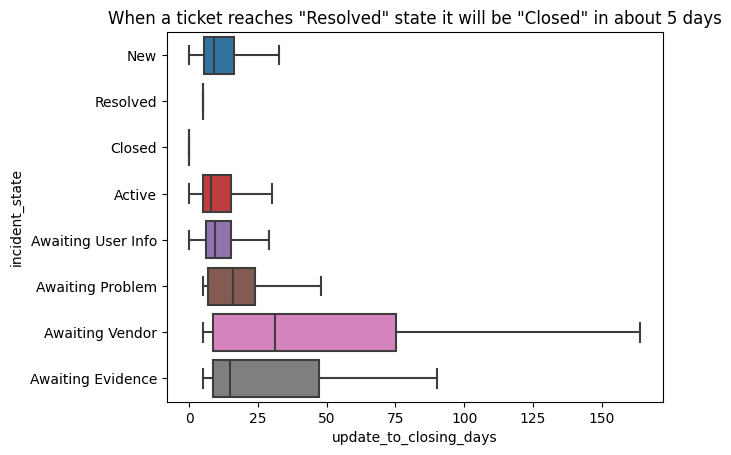

In [538]:
df['update_to_closing_days'] = df['closed_at']-df['sys_updated_at']
df['update_to_closing_days'] = df['update_to_closing_days'].dt.days + df['update_to_closing_days'].dt.seconds / (24 * 60 * 60)
sns.boxplot(df, x='update_to_closing_days', y='incident_state', showfliers=False)
plt.title('When a ticket reaches "Resolved" state it will be "Closed" in about 5 days')
plt.show()

In [539]:
df.loc[df['incident_state']=='Resolved', 'number'].unique().shape

(20765,)

In [540]:
# There are only 3 incidents that were closed but skipped resolved.
filtered_nums = df.groupby('number')['incident_state'].apply(lambda x: ('Closed' in x.values) and ('Resolved' not in x.values))
no_resolved = filtered_nums[filtered_nums].index.to_list()
no_resolved

['INC0003115', 'INC0005100', 'INC0020014']

In [541]:
# There is one ticket that has no entry for Resolved or Closed state. It has however a `closed_at` information.
filtered_nums = df.groupby('number')['incident_state'].apply(lambda x: ('Closed' not in x.values) and ('Resolved' not in x.values))
no_resolved = filtered_nums[filtered_nums].index.to_list()
df[df['number'].isin(no_resolved)]

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,duration_days,update_duration_days,update_to_closing_days
119997,INC0029233,New,True,0.0,0.0,0.0,True,Caller 3033,Opened by 17,2016-05-13 11:49:00,NaN,NaT,Updated by 908,2016-05-13 11:49:00,Phone,Location 97,Category 61,Subcategory 36,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 73,NaN,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 6,Resolved by 180,17/5/2016 16:46,2016-05-22 17:07:00,9.220833,NaN,9.220833


### Missing values

In [542]:
df.loc[(df['sys_created_at'].isna()) & (df['incident_state']=='New'), 'priority'].value_counts()

priority
3 - Moderate    9132
2 - High         316
1 - Critical     263
4 - Low          192
Name: count, dtype: int64

In [543]:
df.loc[(df['sys_created_at'].isna()) & (df['incident_state']=='Closed'), 'sys_mod_count'].value_counts()

sys_mod_count
2.0      3264
1.0      1396
3.0      1228
4.0       601
5.0       405
         ... 
102.0       1
57.0        1
72.0        1
62.0        1
90.0        1
Name: count, Length: 64, dtype: int64

In [544]:
df.loc[(df['update_to_closing_days'].isna()), 'priority'].value_counts()

Series([], Name: count, dtype: int64)

## Feature Engineering
We already did a bit of feature engineering in an earlier step when we computed the time between updates (`update_duration_days`) and the **target** (`update_to_closing_days`). The column `duration_days` cannot be used as feature because it leaks the closing information. Columns that give information regarding *resolution** or *closing* will also be removed. We will also be removing columns that we believe were only filled in as the ticket was being investigated but were broadcasted among all `incident_state`. We can *guess* that these items were filled in during the **Active** state, but there are tickets that have had multiple **Active** states so it is better to operate on minimal information. We also removed the `active` column since it only becomes **False** when the ticket is **Closed** except for one outlier (`Active==False & incident_state==Resolved`). The identifier `number` will only be dropped later as it will be used in train-test-split.

In [545]:
df = df[all_cols].copy()
df.sample(5)

,number,caller_id,opened_by,sys_created_by,sys_updated_by,contact_type,location,u_symptom,incident_state,reassignment_count,reopen_count,sys_mod_count,impact,urgency,priority,cmdb_ci,u_priority_confirmation,opened_at,sys_created_at,sys_updated_at,closed_at
115448,INC0028023,Caller 4749,Opened by 467,NaN,Updated by 335,Phone,Location 93,Symptom 86,Resolved,0.0,0.0,2.0,2 - Medium,1 - High,2 - High,NaN,True,2016-05-10 16:37:00,NaT,2016-05-11 08:27:00,2016-05-16 09:07:00
14931,INC0003354,Caller 3479,Opened by 17,NaN,Updated by 874,Phone,Location 143,NaN,Awaiting User Info,2.0,0.0,5.0,2 - Medium,2 - Medium,3 - Moderate,NaN,False,2016-03-07 11:30:00,NaT,2016-03-09 16:50:00,2016-03-24 18:50:00
32406,INC0007254,Caller 4988,Opened by 17,NaN,Updated by 908,Phone,Location 93,Symptom 534,Active,0.0,0.0,0.0,2 - Medium,2 - Medium,3 - Moderate,NaN,False,2016-03-15 12:03:00,NaT,2016-03-15 12:03:00,2016-03-24 19:01:00
86315,INC0020676,Caller 4394,Opened by 8,NaN,Updated by 21,Phone,Location 108,Symptom 116,Active,2.0,0.0,3.0,2 - Medium,2 - Medium,3 - Moderate,NaN,False,2016-04-19 01:04:00,NaT,2016-04-19 03:09:00,2016-04-24 04:07:00
101233,INC0024545,Caller 2717,Opened by 17,NaN,Updated by 908,Phone,Location 161,Symptom 116,New,0.0,0.0,0.0,2 - Medium,2 - Medium,3 - Moderate,NaN,False,2016-05-01 12:19:00,NaT,2016-05-01 12:19:00,2016-05-06 14:07:00


In [546]:
df['update_to_closing_days'] = df['closed_at']-df['sys_updated_at']
df['update_to_closing_days'] = df['update_to_closing_days'].dt.days + df['update_to_closing_days'].dt.seconds / (24 * 60 * 60)

df.drop('closed_at', axis=1, inplace=True)

We use sklearn to create transformers for feature engineering.
First function computes for time between updates

In [547]:
from sklearn.preprocessing import FunctionTransformer

# Define the transformation function
def update_duration_transformer(X):
    # Sort the DataFrame by 'number' and 'sys_updated_at'
    X.sort_values(['number', 'sys_updated_at'], inplace=True)

    # Calculate the time difference between updates for the same 'number'
    X['update_duration_days'] = X.groupby('number')['sys_updated_at'].diff().dt.total_seconds() / (3600 * 24)

    return X

# Create a FunctionTransformer using the defined function
update_duration_transform = FunctionTransformer(update_duration_transformer)

# Example usage:
# update_duration_transform.fit_transform(df).sample(5)


We split the *Date time columns* into its components so the algorithms can handle them.

In [548]:
# for col in dt_cols:

# df.drop(columns=dt_cols, inplace=True)
# df.sample()

def split_dt_parts_transformer(X):
    cols = X.select_dtypes(include=['datetime64']).columns.to_list()
    for col in cols:
        for component in ['year', 'month', 'day', 'hour', 'minute', 'second']:
            new_col_name = f'{col}_{component}'  # Create a dynamic column name
            X[new_col_name] = X[col].dt.__getattribute__(component).astype(float)
    # Drop the original datetime columns
    cols.append('number')
    X.drop(columns=cols, inplace=True)

    return X

split_dt_parts = FunctionTransformer(split_dt_parts_transformer)
# split_dt_parts.fit_transform(df).sample(5)

## Modelling (Pipeline)

In [549]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor

In [550]:
# Create the column transformer
# numeric_features = ['numerical_col1']
dt_cols.remove('closed_at')
dt_cols.append('number')
categorical_features = cardinal_cols + ordinal_cols + boolean_cols
datetime_features = dt_cols

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

datetime_transformer = Pipeline(steps=[
    ('update_duration_transform', update_duration_transform),
    ('split_dt_parts_transform', split_dt_parts),
    ('imputer', SimpleImputer(strategy='mean')),
])

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('datetime', datetime_transformer, datetime_features)
    ], remainder='drop'
)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBRegressor())])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['number', 'caller_id',
                                                   'opened_by',
                                                   'sys_created_by',
                                                   'sys_updated_by',
                                                   'contact_type', 'location',
                                                   'u_symptom',
                                                   'incident_state',
                                                   'reassignment_count',
                                                   'reopen_count',
                                                   'sys_mod_count', 'impa...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])